Accuracy: 0.8333333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91        52
           1       0.00      0.00      0.00         8

    accuracy                           0.83        60
   macro avg       0.43      0.48      0.45        60
weighted avg       0.75      0.83      0.79        60


Confusion Matrix:
 [[50  2]
 [ 8  0]]


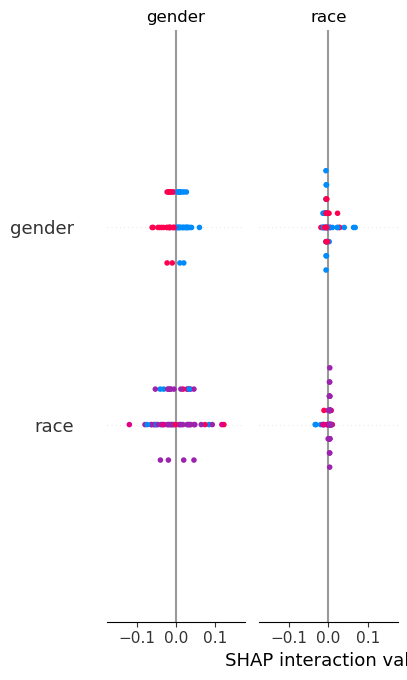

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap
import matplotlib.pyplot as plt

# --------------------------
# 1. Load & preprocess data
# --------------------------
df = pd.read_csv("diabetic_data.csv")

# Drop unwanted columns
df.drop(['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)
df = df[df['gender'] != 'Unknown/Invalid']
df.dropna(inplace=True)

# Encode target: 1 for <30 (readmitted), else 0
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Encode categorical features
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Split features and target
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# DataFrames with column names
X_df = pd.DataFrame(X_scaled, columns=X.columns)

# --------------------------
# 2. Train-test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

# --------------------------
# 3. Train Random Forest
# --------------------------
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train model on balanced data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)

# --------------------------
# 4. Evaluate Model
# --------------------------
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --------------------------
# 5. SHAP Explainability
# --------------------------
# Create a sample for explanation
sample_size = min(100, len(X_test))
X_sample = X_test.sample(sample_size, random_state=42)

# SHAP Explainer
explainer = shap.Explainer(rf, X_sample)

# Disable strict additivity check
shap_values = explainer(X_sample, check_additivity=False)

# Summary plot
shap.summary_plot(shap_values, X_sample, feature_names=X.columns)

In [11]:
print("Class distribution:\n", y_train.value_counts())

Class distribution:
 readmitted
0    210
1     28
Name: count, dtype: int64


In [15]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        52
           1       0.00      0.00      0.00         8

    accuracy                           0.83        60
   macro avg       0.43      0.48      0.45        60
weighted avg       0.75      0.83      0.79        60



In [ ]:
print("Unique predictions:", np.unique(y_pred, return_counts=True))

